In [1]:
import os
import geopandas as gp
import pandas as pd
import numpy as np
wd = os.getcwd()
raw_from_source = os.path.join(wd,'raw-from-source')

# Hawai'i 2022 Election Results and Precinct Boundaries Processing

- Hawai'i 2022 General Election Precinct Results from [MEDSL](https://github.com/MEDSL/2022-elections-official/tree/main/individual_states)
- Hawai'i Precinct Boundaries from the [Hawai'i Statewide GIS Program](https://geoportal.hawaii.gov/datasets/HiStateGIS::election-precincts/explore?location=20.555300%2C-157.490700%2C8.41)
- Official PDF Precinct Level Results from [Hawai'i Office of Elections](https://elections.hawaii.gov/election-results/)

Import MEDSL Precinct Results

In [2]:
elec = pd.read_csv(os.path.join(raw_from_source,'HI-cleaned.csv'))
elec.head()

,precinct,district,office,writein,party_detailed,party_simplified,candidate,dataverse,mode,votes,...,state_fips,state_cen,state_ic,date,jurisdiction_fips,county_name,county_fips,readme_check,magnitude,special
0,01-01,NaN,US SENATE,False,REPUBLICAN,REPUBLICAN,BOB MCDERMOTT,SENATE,MAIL IN,609,...,15,95,82,2022-11-08,15001,HAWAII,15001,False,1,False
1,01-01,NaN,US SENATE,False,ALOHA AINA PARTY,OTHER,EMMA JANE A POHLMAN,SENATE,MAIL IN,29,...,15,95,82,2022-11-08,15001,HAWAII,15001,False,1,False
2,01-01,NaN,US SENATE,False,ALOHA AINA PARTY,OTHER,BRIAN SCHATZ,SENATE,MAIL IN,2521,...,15,95,82,2022-11-08,15001,HAWAII,15001,False,1,False
3,01-01,2.0,US HOUSE,False,ALOHA AINA PARTY,OTHER,JOE AKANA,HOUSE,MAIL IN,864,...,15,95,82,2022-11-08,15001,HAWAII,15001,False,1,False
4,01-01,2.0,US HOUSE,False,LIBERTARIAN,LIBERTARIAN,MICHELLE ROSE TIPPENS,HOUSE,MAIL IN,84,...,15,95,82,2022-11-08,15001,HAWAII,15001,False,1,False


Clean fields and create a unique contest field (combine office and district fields)

In [3]:
elec['district'] = elec['district'].apply(lambda x: str(x).split('.')[0])
elec['district'] = elec['district'].apply(lambda x: x.strip())
elec['office'] = elec['office'].apply(lambda x: x.strip())
elec['contest_name'] = elec.apply(lambda x: x['office']+ ' - '+x['district']  if x['district']!='nan' else x['office'],axis=1)

Check which contests are in all precincts

In [37]:
unique_precincts = list(elec['precinct'].unique())
all_contests = sorted(list(elec['contest_name'].unique()))
len_all_contests = len(all_contests)
listofzeros = [0] * len_all_contests
num_precs = len(unique_precincts)
contests_dict = dict(zip(all_contests,listofzeros))
in_all_precincts = []
for i in unique_precincts:
    sub_df = elec[elec['precinct']==i]
    contests = list(sub_df['contest_name'].unique())
    for contest in contests:
        contests_dict[contest] = int(contests_dict.get(contest))+1
contests_keep =[]
for k,v in contests_dict.items():
    if v>200:
        print(k,'\t',v)
        contests_keep.append(k)
print(contests_keep)

AT-LARGE TRUSTEE 	 234
GOVERNOR 	 236
HAWAII RESIDENT TRUSTEE VACANCY 	 235
US SENATE 	 236
['AT-LARGE TRUSTEE', 'GOVERNOR', 'HAWAII RESIDENT TRUSTEE VACANCY', 'US SENATE']


In [32]:
for i in unique_precincts:
    sub_df = elec[elec['precinct']==i]
    sub_contests = list(sub_df['contest_name'].unique())
    for cont in contests_keep:
        if cont not in sub_contests:
            print(cont, ' is missing from: ', i)

AT-LARGE TRUSTEE  is missing from:  05-04
AT-LARGE TRUSTEE  is missing from:  01-04
HAWAII RESIDENT TRUSTEE VACANCY  is missing from:  01-04


Query file to just the contests of interest

In [33]:
contests_keep = contests_keep+['STATE HOUSE - 11', 'STATE HOUSE - 12', 'STATE HOUSE - 13', 'STATE HOUSE - 14', 'STATE HOUSE - 15', 'STATE HOUSE - 16', 'STATE HOUSE - 17', 'STATE HOUSE - 19', 'STATE HOUSE - 20', 'STATE HOUSE - 21', 'STATE HOUSE - 22', 'STATE HOUSE - 24', 'STATE HOUSE - 25', 'STATE HOUSE - 26', 'STATE HOUSE - 27', 'STATE HOUSE - 28', 'STATE HOUSE - 29', 'STATE HOUSE - 3', 'STATE HOUSE - 30', 'STATE HOUSE - 32', 'STATE HOUSE - 34', 'STATE HOUSE - 35', 'STATE HOUSE - 36', 'STATE HOUSE - 37', 'STATE HOUSE - 38', 'STATE HOUSE - 39', 'STATE HOUSE - 4', 'STATE HOUSE - 40', 'STATE HOUSE - 41', 'STATE HOUSE - 42', 'STATE HOUSE - 43', 'STATE HOUSE - 44', 'STATE HOUSE - 45', 'STATE HOUSE - 46', 'STATE HOUSE - 47', 'STATE HOUSE - 48', 'STATE HOUSE - 49', 'STATE HOUSE - 5', 'STATE HOUSE - 50', 'STATE HOUSE - 51', 'STATE HOUSE - 6', 'STATE HOUSE - 8', 'STATE SENATOR - 1', 'STATE SENATOR - 10', 'STATE SENATOR - 11', 'STATE SENATOR - 12', 'STATE SENATOR - 13', 'STATE SENATOR - 14', 'STATE SENATOR - 15', 'STATE SENATOR - 16', 'STATE SENATOR - 17', 'STATE SENATOR - 18', 'STATE SENATOR - 2', 'STATE SENATOR - 21', 'STATE SENATOR - 22', 'STATE SENATOR - 23', 'STATE SENATOR - 24', 'STATE SENATOR - 25', 'STATE SENATOR - 4', 'STATE SENATOR - 6', 'STATE SENATOR - 7', 'STATE SENATOR - 8', 'STATE SENATOR - 9', 'US HOUSE - 1', 'US HOUSE - 2', 'US SENATE']
cols_keep = ['precinct','contest_name','district','office','party_detailed','candidate','dataverse','mode','votes','county_name','county_fips']
elec_keep = elec[elec['contest_name'].isin(contests_keep)]
elec_keep = elec_keep[cols_keep]
elec_keep

,precinct,contest_name,district,office,party_detailed,candidate,dataverse,mode,votes,county_name,county_fips
0,01-01,US SENATE,nan,US SENATE,REPUBLICAN,BOB MCDERMOTT,SENATE,MAIL IN,609,HAWAII,15001
1,01-01,US SENATE,nan,US SENATE,ALOHA AINA PARTY,EMMA JANE A POHLMAN,SENATE,MAIL IN,29,HAWAII,15001
2,01-01,US SENATE,nan,US SENATE,ALOHA AINA PARTY,BRIAN SCHATZ,SENATE,MAIL IN,2521,HAWAII,15001
3,01-01,US HOUSE - 2,2,US HOUSE,ALOHA AINA PARTY,JOE AKANA,HOUSE,MAIL IN,864,HAWAII,15001
4,01-01,US HOUSE - 2,2,US HOUSE,LIBERTARIAN,MICHELLE ROSE TIPPENS,HOUSE,MAIL IN,84,HAWAII,15001
...,...,...,...,...,...,...,...,...,...,...,...
16539,51-05,AT-LARGE TRUSTEE,nan,AT-LARGE TRUSTEE,ALOHA AINA PARTY,BRICKWOOD GALUTERIA,STATE,ELECTION DAY,12,HONOLULU,15003
16540,51-05,AT-LARGE TRUSTEE,nan,AT-LARGE TRUSTEE,GREEN,SAM 'KALANIKUPUA' KING,STATE,ELECTION DAY,21,HONOLULU,15003
16541,51-05,AT-LARGE TRUSTEE,nan,AT-LARGE TRUSTEE,NaN,CHAD OWENS,STATE,ELECTION DAY,20,HONOLULU,15003
16542,51-05,AT-LARGE TRUSTEE,nan,AT-LARGE TRUSTEE,ALOHA AINA PARTY,KEONI SOUZA,STATE,ELECTION DAY,31,HONOLULU,15003


Read in shapefile and check what column is unique or the closest to being unique.

In [40]:
precincts = gp.read_file(os.path.join(raw_from_source,'Election_Precincts.geojson'))
print(list(precincts.columns))

['objectid', 'dp', 'dpnum', 'dptype', 'county', 'zeropop', 'ballottype_50', 'us_house', 'state_house', 'state_senate', 'county_council', 'st_areashape', 'st_perimetershape', 'geometry']


In [42]:
precincts = gp.read_file(os.path.join(raw_from_source,'Election_Precincts.geojson'))
col_len_dict = {}
prec_len = len(precincts)
for i in list(precincts.columns):
    if i not in ['geometry','objectid','st_areashape','st_perimetershape']:
        unique_count = len(precincts[i].unique())
        col_len_dict.update({i:unique_count})
best_fit = ''
best_fit_len = 0
for k,v in col_len_dict.items():
    if best_fit =='':
        best_fit = k
        best_fit_len = v
    else:
        if v>best_fit_len:
            best_fit = k
            best_fit_len = v
print(best_fit)
print('Difference between unique precincts and lenght of best fit column for unique ID: ', prec_len - best_fit_len)

dp
248
Difference between unique precincts and lenght of best fit column for unique ID:  2


Determine where columns 'dp' has the same values.

42-01


,objectid,dp,dpnum,dptype,county,zeropop,ballottype_50,us_house,state_house,state_senate,county_council,st_areashape,st_perimetershape,geometry,duplicated
246,247,42-01,4201,VBMO,OAHU,,CD1-H42-S20-CC9,CD1,H42,S20,CC9,92198.471050,1370.015977,"POLYGON ((-158.03044 21.33709, -158.02942 21.3...",False
247,248,42-01,4201,VBMO,OAHU,,CD1-H42-S20-CC9,CD1,H42,S20,CC9,215295.378292,2002.045649,"POLYGON ((-158.02814 21.34041, -158.02769 21.3...",True


18-05


,objectid,dp,dpnum,dptype,county,zeropop,ballottype_50,us_house,state_house,state_senate,county_council,st_areashape,st_perimetershape,geometry,duplicated
248,249,18-05,1805,VBMO,OAHU,,CD1-H18-S09-CC4,CD1,H18,S09,CC4,2.572862e+05,2852.785704,"POLYGON ((-157.71873 21.28422, -157.71872 21.2...",False
249,250,18-05,1805,VBMO,OAHU,,CD1-H18-S09-CC4,CD1,H18,S09,CC4,2.780304e+06,11075.929342,"POLYGON ((-157.70717 21.31775, -157.70734 21.3...",True


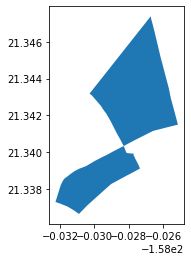

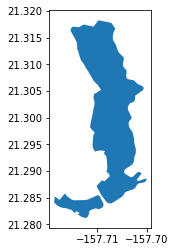

In [47]:
precincts['duplicated'] = precincts.duplicated(subset=best_fit)
duplicated_values = list(precincts[precincts['duplicated']==True][best_fit].unique())
for i in duplicated_values:
    dup_gdf = precincts[precincts[best_fit]==i]
    print(i)
    display(dup_gdf)
    dup_gdf.plot()

Duplicated precincts should be multi-poloygons so dissolve on 'dp' to make the field unique

In [49]:
precs = precincts.dissolve(by=best_fit)
precs.reset_index(inplace=True,drop=False)
precs.head()

,dp,geometry,objectid,dpnum,dptype,county,zeropop,ballottype_50,us_house,state_house,state_senate,county_council,st_areashape,st_perimetershape,duplicated
0,01-01,"POLYGON ((-155.69865 20.18589, -155.69903 20.1...",1,101,VBMO,HAWAII,,CD2-H01-S04-CC1,CD2,H01,S04,CC1,9.949400e+08,243835.454121,False
1,01-02,"POLYGON ((-155.08329 19.85094, -155.08329 19.8...",2,102,VBMO,HAWAII,,CD2-H01-S01-CC1,CD2,H01,S01,CC1,1.996375e+08,90596.525487,False
2,01-03,"POLYGON ((-155.33399 19.78996, -155.33422 19.7...",3,103,VBMO,HAWAII,,CD2-H01-S01-CC2,CD2,H01,S01,CC2,4.157142e+08,96097.575789,False
3,01-04,"POLYGON ((-155.43905 19.90430, -155.43920 19.9...",4,104,ZEROPOP,HAWAII,yes,CD2-H01-S04-CC2,CD2,H01,S04,CC2,4.202857e+08,100538.651270,False
4,02-01,"POLYGON ((-155.08683 19.72785, -155.08688 19.7...",5,201,VBMO,HAWAII,,CD2-H02-S01-CC2,CD2,H02,S01,CC2,1.954235e+07,28533.769583,False


In [10]:
elec_precs_list = sorted(list(elec_keep['precinct'].unique()))
shp_precs_list = sorted(list(precs['dp'].unique()))
print(elec_precs_list)
print(shp_precs_list)

['01-01', '01-02', '01-03', '01-04', '02-01', '02-02', '02-03', '02-04', '03-01', '03-02', '03-03', '03-04', '03-05', '04-01', '04-02', '04-03', '05-02', '05-03', '05-04', '05-05', '05-06', '06-01', '06-02', '06-03', '06-04', '07-01', '07-02', '07-03', '07-04', '07-05', '08-01', '08-02', '08-03', '08-04', '09-01', '09-02', '09-03', '09-04', '09-05', '10-01', '10-02', '10-03', '10-04', '10-05', '10-06', '10-07', '11-01', '11-02', '11-03', '11-04', '12-01', '12-02', '12-03', '12-04', '12-05', '13-01', '13-02', '13-03', '13-04', '13-05', '13-06', '13-07', '13-08', '13-09', '14-01', '14-02', '14-03', '14-04', '14-05', '15-01', '15-02', '15-03', '15-04', '15-05', '16-01', '16-02', '16-03', '16-04', '16-05', '17-01', '17-02', '17-03', '17-04', '17-05', '17-06', '18-01', '18-02', '18-03', '18-04', '18-05', '19-01', '19-02', '19-03', '19-04', '20-01', '20-02', '20-03', '20-04', '20-05', '21-01', '21-02', '21-03', '21-04', '22-01', '22-02', '22-03', '22-04', '22-05', '23-01', '23-02', '23-03', 

In [11]:
elec_only = []
for i in elec_precs_list:
    if i not in shp_precs_list:
        elec_only.append(i)
print(elec_only)
shp_only = []
for i in shp_precs_list:
    if i not in elec_precs_list:
        shp_only.append(i)
print(shp_only)

[]
['04-04', '05-01', '05-07', '05-08', '05-09', '05-10', '07-06', '07-07', '13-10', '36-04', '37-04', '46-01']


In [12]:
print(len(shp_only) + len(elec_precs_list))
print(len(precs))

248
248


In [13]:
no_vote_precs = precs[precs['dp'].isin(shp_only)]
print(len(no_vote_precs))
print(len(shp_only))

12
12


In [15]:
no_vote_precs.to_file('./no_vote_precs.geojson',driver='GeoJSON')

DriverError: Failed to create GeoJSON datasource: ./no_vote_precs.geojson: 

In [16]:
no_vote_not_zero_pop = no_vote_precs[no_vote_precs['zeropop']!='yes']
no_vote_not_zero_pop

,dp,geometry,objectid,dpnum,dptype,county,zeropop,ballottype_50,us_house,state_house,state_senate,county_council,st_areashape,st_perimetershape
17,05-01,"POLYGON ((-155.13740 19.62195, -155.14280 19.6...",18,501,VBMO,HAWAII,,CD2-H05-S01-CC3,CD2,H05,S01,CC3,1.854035e+08,78107.365466
23,05-07,"POLYGON ((-155.75375 19.40661, -155.75355 19.4...",24,507,VBMO,HAWAII,,CD2-H05-S03-CC7,CD2,H05,S03,CC7,3.949095e+08,98535.979073
216,46-01,"POLYGON ((-158.02476 21.42415, -158.02491 21.4...",215,4601,VBMO,OAHU,,CD2-H46-S18-CC2,CD2,H46,S18,CC2,4.278015e+06,13354.128507


In [17]:
col_name_dict = {'US SENATE':'G22USS','AT-LARGE TRUSTEE':'G22ALT','GOVERNOR':'G22GOV','HAWAII RESIDENT TRUSTEE VACANCY':'G22RTV'}

for i in sorted(elec_keep['contest_name'].unique()):
    if i not in col_name_dict.keys():
        dist_num = str(str(i.split(' - ')[1]).zfill(2))
        if 'STATE HOUSE' in i:
            name = 'GSLL'+dist_num
        elif 'STATE SEN' in i:
            name = 'GSLU'+dist_num
        else:
            name = 'GCON'+dist_num
        col_name_dict.update({i:name})

In [18]:
elec_keep['base_name'] = elec_keep['contest_name'].map(col_name_dict)
elec_keep['party_letter'] = elec_keep['party_detailed'].apply(lambda x: str(x)[0].upper())
elec_keep['name3'] = elec_keep['candidate'].apply(lambda x: str(x).split(' ')[-1][0:3])
elec_keep['name3'] = elec_keep['name3'].apply(lambda x: str(x)+'K' if x=='HO' else x)
elec_keep['full_name'] = elec_keep['base_name']+elec_keep['party_letter']+elec_keep['name3']
cols_keep = ['precinct','votes','full_name']
elec_sub = elec_keep[cols_keep]
display(elec_sub)

,precinct,votes,full_name
0,01-01,609,G22USSRMCD
1,01-01,29,G22USSAPOH
2,01-01,2521,G22USSASCH
3,01-01,864,GCON02AAKA
4,01-01,84,GCON02LTIP
...,...,...,...
16539,51-05,12,G22ALTAGAL
16540,51-05,21,G22ALTGKIN
16541,51-05,20,G22ALTNOWE
16542,51-05,31,G22ALTASOU


In [19]:
pivot = elec_sub.pivot_table(index='precinct',columns = ['full_name'],values=['votes'],aggfunc=sum)
pivot.reset_index(inplace=True,drop=False)
pivot.columns = [col[1] for col in pivot.columns]
pivot.rename(columns = {'':'UNIQUE_ID'},inplace=True)
for i in pivot.columns:
    if i == 'UNIQUE_ID':
        pivot[i] = pivot[i].apply(lambda x: str(x))
    else:
        pivot[i] = pivot[i].fillna(0)
        pivot[i] = pivot[i].apply(lambda x: int(x))
pivot

,UNIQUE_ID,G22ALTAGAL,G22ALTAISA,G22ALTASOU,G22ALTAWAI,G22ALTGKIN,G22ALTNOWE,G22GOVAAIO,G22GOVAGRE,G22RTVACER,...,GSLU21AGAB,GSLU21AKHA,GSLU22ASHI,GSLU22RDEC,GSLU23AAWA,GSLU23GRIV,GSLU24AFER,GSLU24AKEO,GSLU25ALAU,GSLU25LLEE
0,01-01,1098,746,1309,1164,764,765,985,2343,816,...,0,0,0,0,0,0,0,0,0,0
1,01-02,689,559,772,810,502,544,675,1544,532,...,0,0,0,0,0,0,0,0,0,0
2,01-03,1149,813,1189,1086,662,805,1098,2243,739,...,0,0,0,0,0,0,0,0,0,0
3,01-04,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,02-01,1916,1268,1595,1845,1024,1274,1503,3687,1173,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,51-01,568,379,541,437,599,415,614,1245,504,...,0,0,0,0,0,0,0,0,490,1319
232,51-02,950,696,972,702,826,796,953,1773,727,...,0,0,0,0,0,0,0,0,758,1876
233,51-03,779,619,765,654,598,607,786,1431,584,...,0,0,0,0,0,0,0,0,594,1573
234,51-04,550,426,677,434,284,520,586,694,334,...,0,0,0,0,0,0,0,0,393,860


In [20]:
precs['dp'] = precs['dp'].apply(lambda x: str(x))
precs['county'] = precs['county'].apply(lambda x: 'HONOLULU' if x=='OAHU' else x)
precs['county_fips'] = precs['county'].map({'HAWAII': '15001', 'MAUI': '15009', 'KAUAI': '15007', 'HONOLULU': '15003'})
col_dict =  {'dp':'UNIQUE_ID','county':'COUNTYNM','county_fips':'COUNTYFP','us_house':'CON_DIST','state_house':'SLL_DIST','state_senate':'SLU_DIST'}
precs.rename(columns =col_dict,inplace=True)

In [21]:
precs_keep = precs[list(col_dict.values())+['geometry']]
precs_keep

,UNIQUE_ID,COUNTYNM,COUNTYFP,CON_DIST,SLL_DIST,SLU_DIST,geometry
0,01-01,HAWAII,15001,CD2,H01,S04,"POLYGON ((-155.69865 20.18589, -155.69903 20.1..."
1,01-02,HAWAII,15001,CD2,H01,S01,"POLYGON ((-155.08329 19.85094, -155.08329 19.8..."
2,01-03,HAWAII,15001,CD2,H01,S01,"POLYGON ((-155.33399 19.78996, -155.33422 19.7..."
3,01-04,HAWAII,15001,CD2,H01,S04,"POLYGON ((-155.43905 19.90430, -155.43920 19.9..."
4,02-01,HAWAII,15001,CD2,H02,S01,"POLYGON ((-155.08683 19.72785, -155.08688 19.7..."
...,...,...,...,...,...,...,...
243,51-01,HONOLULU,15003,CD2,H51,S25,"POLYGON ((-157.72408 21.39660, -157.72457 21.3..."
244,51-02,HONOLULU,15003,CD2,H51,S25,"POLYGON ((-157.73704 21.36964, -157.73692 21.3..."
245,51-03,HONOLULU,15003,CD2,H51,S25,"POLYGON ((-157.71736 21.37975, -157.71840 21.3..."
246,51-04,HONOLULU,15003,CD2,H51,S25,"POLYGON ((-157.70963 21.36491, -157.70969 21.3..."


In [22]:
joined = pd.merge(precs_keep,pivot,how='outer',indicator=False)
for i in joined.columns:
    if i != 'UNIQUE_ID':
        joined[i] = joined[i].fillna(0)
joined
#no_merge = joined[joined['_merge']!='both']
#no_merge

,UNIQUE_ID,COUNTYNM,COUNTYFP,CON_DIST,SLL_DIST,SLU_DIST,geometry,G22ALTAGAL,G22ALTAISA,G22ALTASOU,...,GSLU21AGAB,GSLU21AKHA,GSLU22ASHI,GSLU22RDEC,GSLU23AAWA,GSLU23GRIV,GSLU24AFER,GSLU24AKEO,GSLU25ALAU,GSLU25LLEE
0,01-01,HAWAII,15001,CD2,H01,S04,"POLYGON ((-155.69865 20.18589, -155.69903 20.1...",1098.0,746.0,1309.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01-02,HAWAII,15001,CD2,H01,S01,"POLYGON ((-155.08329 19.85094, -155.08329 19.8...",689.0,559.0,772.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01-03,HAWAII,15001,CD2,H01,S01,"POLYGON ((-155.33399 19.78996, -155.33422 19.7...",1149.0,813.0,1189.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01-04,HAWAII,15001,CD2,H01,S04,"POLYGON ((-155.43905 19.90430, -155.43920 19.9...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,02-01,HAWAII,15001,CD2,H02,S01,"POLYGON ((-155.08683 19.72785, -155.08688 19.7...",1916.0,1268.0,1595.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,51-01,HONOLULU,15003,CD2,H51,S25,"POLYGON ((-157.72408 21.39660, -157.72457 21.3...",568.0,379.0,541.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,490.0,1319.0
244,51-02,HONOLULU,15003,CD2,H51,S25,"POLYGON ((-157.73704 21.36964, -157.73692 21.3...",950.0,696.0,972.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,758.0,1876.0
245,51-03,HONOLULU,15003,CD2,H51,S25,"POLYGON ((-157.71736 21.37975, -157.71840 21.3...",779.0,619.0,765.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,594.0,1573.0
246,51-04,HONOLULU,15003,CD2,H51,S25,"POLYGON ((-157.70963 21.36491, -157.70969 21.3...",550.0,426.0,677.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,393.0,860.0


In [23]:
index_val = joined.index[joined['UNIQUE_ID'] == '01-01']
display(joined.head(1))
joined.loc[index_val,'G22USSABON']=39
joined.loc[index_val,'G22USSADEC']=19
display(joined.head(1))

#.loc['01-01']

,UNIQUE_ID,COUNTYNM,COUNTYFP,CON_DIST,SLL_DIST,SLU_DIST,geometry,G22ALTAGAL,G22ALTAISA,G22ALTASOU,...,GSLU21AGAB,GSLU21AKHA,GSLU22ASHI,GSLU22RDEC,GSLU23AAWA,GSLU23GRIV,GSLU24AFER,GSLU24AKEO,GSLU25ALAU,GSLU25LLEE
0,01-01,HAWAII,15001,CD2,H01,S04,"POLYGON ((-155.69865 20.18589, -155.69903 20.1...",1098.0,746.0,1309.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,UNIQUE_ID,COUNTYNM,COUNTYFP,CON_DIST,SLL_DIST,SLU_DIST,geometry,G22ALTAGAL,G22ALTAISA,G22ALTASOU,...,GSLU21AGAB,GSLU21AKHA,GSLU22ASHI,GSLU22RDEC,GSLU23AAWA,GSLU23GRIV,GSLU24AFER,GSLU24AKEO,GSLU25ALAU,GSLU25LLEE
0,01-01,HAWAII,15001,CD2,H01,S04,"POLYGON ((-155.69865 20.18589, -155.69903 20.1...",1098.0,746.0,1309.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
joined.to_file('./completed_hawaii.geojson',driver='GeoJSON')

DriverError: Failed to create GeoJSON datasource: ./completed_hawaii.geojson: 

In [94]:
con_fields = []
sll_fields = []
slu_fields = []
for i in list(joined.columns):
    if i.startswith('GCON'):
        con_fields.append(i)
    elif i.startswith('GSLL'):
        sll_fields.append(i)
    elif i.startswith('GSLU'):
        slu_fields.append(i)

In [95]:
'GCON01ACAS'[4:6]

'01'

In [96]:
for i in list(joined['UNIQUE_ID']):
    sub_df = joined[joined['UNIQUE_ID']==i]
    #display(sub_df)
    con_dist = [list(sub_df['CON_DIST'])[0].replace('CD','').zfill(2)]
    sll_dist = [list(sub_df['SLL_DIST'])[0].replace('H','').zfill(2)]
    slu_dist = [list(sub_df['SLU_DIST'])[0].replace('S','').zfill(2)]
    con_o0 = []
    for col in con_fields:
        if sub_df[col].sum()>0:
            dist = str(col[4:6])
            con_o0.append(dist)
    con_o0 = list(set(con_o0))
    sll_o0 = []
    for col in sll_fields:
        if sub_df[col].sum()>0:
            dist = str(col[4:6])
            sll_o0.append(dist)
    sll_o0 = list(set(sll_o0))
    slu_o0 = []
    for col in slu_fields:
        if sub_df[col].sum()>0:
            dist = str(col[4:6])
            slu_o0.append(dist)
    slu_o0 = list(set(slu_o0))
    if con_dist != con_o0:
        print('Difference in CONG for: ', i)
        print('Election CONG: ', con_o0)
        print('SHP CONG: ', con_dist)
        cols_to_check = ['UNIQUE_ID']
        for check in sub_df.columns:
            try:
                if sub_df[check].sum()>0:
                    cols_to_check.append(check)
            except:
                continue
        display(sub_df[cols_to_check])
        print('')
#     if con_dist == con_o0:
#         print(i)
#         print('CONG SHP: ', con_dist)
#         print('CONG ELEC: ', con_o0)
#         print('')
    if sll_dist != sll_o0:
        print('Difference in SLL for: ', i)
        print('Election SLL: ', sll_o0)
        print('SHP SLL: ', sll_dist)
        print('')
#     if sll_dist == sll_o0:
#         print(i)
#         print('SLL SHP: ', sll_dist)
#         print('SLL ELEC: ', sll_o0)
#         print('')
    if slu_dist != slu_o0:
        continue
        print('Difference in SLU for: ', i)
        print('Election SLU: ', slu_o0)
        print('SHP SLU: ', slu_dist)
        print('')
#     if slu_dist == slu_o0:
#         print(i)
#         print('SLU SHP: ', slu_dist)
#         print('SLU ELEC: ', slu_o0)
#         print('')
        

Difference in SLL for:  01-01
Election SLL:  []
SHP SLL:  ['01']

Difference in SLL for:  01-02
Election SLL:  []
SHP SLL:  ['01']

Difference in SLL for:  01-03
Election SLL:  []
SHP SLL:  ['01']

Difference in SLL for:  01-04
Election SLL:  []
SHP SLL:  ['01']

Difference in SLL for:  02-01
Election SLL:  []
SHP SLL:  ['02']

Difference in SLL for:  02-02
Election SLL:  []
SHP SLL:  ['02']

Difference in SLL for:  02-03
Election SLL:  []
SHP SLL:  ['02']

Difference in SLL for:  02-04
Election SLL:  []
SHP SLL:  ['02']

Difference in CONG for:  04-04
Election CONG:  []
SHP CONG:  ['02']


,UNIQUE_ID
16,04-04



Difference in SLL for:  04-04
Election SLL:  []
SHP SLL:  ['04']

Difference in CONG for:  05-01
Election CONG:  []
SHP CONG:  ['02']


,UNIQUE_ID
17,05-01



Difference in SLL for:  05-01
Election SLL:  []
SHP SLL:  ['05']

Difference in CONG for:  05-07
Election CONG:  []
SHP CONG:  ['02']


,UNIQUE_ID
23,05-07



Difference in SLL for:  05-07
Election SLL:  []
SHP SLL:  ['05']

Difference in CONG for:  05-08
Election CONG:  []
SHP CONG:  ['02']


,UNIQUE_ID
24,05-08



Difference in SLL for:  05-08
Election SLL:  []
SHP SLL:  ['05']

Difference in CONG for:  05-09
Election CONG:  []
SHP CONG:  ['02']


,UNIQUE_ID
25,05-09



Difference in SLL for:  05-09
Election SLL:  []
SHP SLL:  ['05']

Difference in CONG for:  05-10
Election CONG:  []
SHP CONG:  ['02']


,UNIQUE_ID
26,05-10



Difference in SLL for:  05-10
Election SLL:  []
SHP SLL:  ['05']

Difference in SLL for:  07-01
Election SLL:  []
SHP SLL:  ['07']

Difference in SLL for:  07-02
Election SLL:  []
SHP SLL:  ['07']

Difference in SLL for:  07-03
Election SLL:  []
SHP SLL:  ['07']

Difference in SLL for:  07-04
Election SLL:  []
SHP SLL:  ['07']

Difference in SLL for:  07-05
Election SLL:  []
SHP SLL:  ['07']

Difference in CONG for:  07-06
Election CONG:  []
SHP CONG:  ['02']


,UNIQUE_ID
36,07-06



Difference in SLL for:  07-06
Election SLL:  []
SHP SLL:  ['07']

Difference in CONG for:  07-07
Election CONG:  []
SHP CONG:  ['02']


,UNIQUE_ID
37,07-07



Difference in SLL for:  07-07
Election SLL:  []
SHP SLL:  ['07']

Difference in SLL for:  09-01
Election SLL:  []
SHP SLL:  ['09']

Difference in SLL for:  09-02
Election SLL:  []
SHP SLL:  ['09']

Difference in SLL for:  09-03
Election SLL:  []
SHP SLL:  ['09']

Difference in SLL for:  09-04
Election SLL:  []
SHP SLL:  ['09']

Difference in SLL for:  09-05
Election SLL:  []
SHP SLL:  ['09']

Difference in SLL for:  10-01
Election SLL:  []
SHP SLL:  ['10']

Difference in SLL for:  10-02
Election SLL:  []
SHP SLL:  ['10']

Difference in SLL for:  10-03
Election SLL:  []
SHP SLL:  ['10']

Difference in SLL for:  10-04
Election SLL:  []
SHP SLL:  ['10']

Difference in SLL for:  10-05
Election SLL:  []
SHP SLL:  ['10']

Difference in SLL for:  10-06
Election SLL:  []
SHP SLL:  ['10']

Difference in SLL for:  10-07
Election SLL:  []
SHP SLL:  ['10']

Difference in CONG for:  13-10
Election CONG:  []
SHP CONG:  ['02']


,UNIQUE_ID
72,13-10



Difference in SLL for:  13-10
Election SLL:  []
SHP SLL:  ['13']

Difference in SLL for:  18-01
Election SLL:  []
SHP SLL:  ['18']

Difference in SLL for:  18-02
Election SLL:  []
SHP SLL:  ['18']

Difference in SLL for:  18-03
Election SLL:  []
SHP SLL:  ['18']

Difference in SLL for:  18-04
Election SLL:  []
SHP SLL:  ['18']

Difference in SLL for:  18-05
Election SLL:  []
SHP SLL:  ['18']

Difference in SLL for:  23-01
Election SLL:  []
SHP SLL:  ['23']

Difference in SLL for:  23-02
Election SLL:  []
SHP SLL:  ['23']

Difference in SLL for:  23-03
Election SLL:  []
SHP SLL:  ['23']

Difference in SLL for:  23-04
Election SLL:  []
SHP SLL:  ['23']

Difference in SLL for:  23-05
Election SLL:  []
SHP SLL:  ['23']

Difference in SLL for:  31-01
Election SLL:  []
SHP SLL:  ['31']

Difference in SLL for:  31-02
Election SLL:  []
SHP SLL:  ['31']

Difference in SLL for:  31-03
Election SLL:  []
SHP SLL:  ['31']

Difference in SLL for:  31-04
Election SLL:  []
SHP SLL:  ['31']

Differenc

,UNIQUE_ID
176,36-04



Difference in SLL for:  36-04
Election SLL:  []
SHP SLL:  ['36']

Difference in CONG for:  37-04
Election CONG:  []
SHP CONG:  ['01']


,UNIQUE_ID
180,37-04



Difference in SLL for:  37-04
Election SLL:  []
SHP SLL:  ['37']

Difference in CONG for:  46-01
Election CONG:  []
SHP CONG:  ['02']


,UNIQUE_ID
216,46-01



Difference in SLL for:  46-01
Election SLL:  []
SHP SLL:  ['46']



In [97]:
for i in sorted(contests_keep):
    print(i)
'''
General Election Cancelled for SLL: 1, 2, 7, 9, 10, 18, 23, 31, 33
'''

AT-LARGE TRUSTEE
GOVERNOR
HAWAII RESIDENT TRUSTEE VACANCY
STATE HOUSE - 11
STATE HOUSE - 12
STATE HOUSE - 13
STATE HOUSE - 14
STATE HOUSE - 15
STATE HOUSE - 16
STATE HOUSE - 17
STATE HOUSE - 19
STATE HOUSE - 20
STATE HOUSE - 21
STATE HOUSE - 22
STATE HOUSE - 24
STATE HOUSE - 25
STATE HOUSE - 26
STATE HOUSE - 27
STATE HOUSE - 28
STATE HOUSE - 29
STATE HOUSE - 3
STATE HOUSE - 30
STATE HOUSE - 32
STATE HOUSE - 34
STATE HOUSE - 35
STATE HOUSE - 36
STATE HOUSE - 37
STATE HOUSE - 38
STATE HOUSE - 39
STATE HOUSE - 4
STATE HOUSE - 40
STATE HOUSE - 41
STATE HOUSE - 42
STATE HOUSE - 43
STATE HOUSE - 44
STATE HOUSE - 45
STATE HOUSE - 46
STATE HOUSE - 47
STATE HOUSE - 48
STATE HOUSE - 49
STATE HOUSE - 5
STATE HOUSE - 50
STATE HOUSE - 51
STATE HOUSE - 6
STATE HOUSE - 8
STATE SENATOR - 1
STATE SENATOR - 10
STATE SENATOR - 11
STATE SENATOR - 12
STATE SENATOR - 13
STATE SENATOR - 14
STATE SENATOR - 15
STATE SENATOR - 16
STATE SENATOR - 17
STATE SENATOR - 18
STATE SENATOR - 2
STATE SENATOR - 21
STATE S

'\nGeneral Election Canceled for SLL: 1, 2, 7, 9, 10, 18, 23, 31, 33\n'

In [98]:
joined

,UNIQUE_ID,COUNTY,COUNTYFP,CON_DIST,SLL_DIST,SLU_DIST,geometry,G22ALTAGAL,G22ALTAISA,G22ALTASOU,...,GSLU21AGAB,GSLU21AKHA,GSLU22ASHI,GSLU22RDEC,GSLU23AAWA,GSLU23GRIV,GSLU24AFER,GSLU24AKEO,GSLU25ALAU,GSLU25LLEE
0,01-01,HAWAII,15001,CD2,H01,S04,"POLYGON ((-155.69865 20.18589, -155.69903 20.1...",1098.0,746.0,1309.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01-02,HAWAII,15001,CD2,H01,S01,"POLYGON ((-155.08329 19.85094, -155.08329 19.8...",689.0,559.0,772.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01-03,HAWAII,15001,CD2,H01,S01,"POLYGON ((-155.33399 19.78996, -155.33422 19.7...",1149.0,813.0,1189.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01-04,HAWAII,15001,CD2,H01,S04,"POLYGON ((-155.43905 19.90430, -155.43920 19.9...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,02-01,HAWAII,15001,CD2,H02,S01,"POLYGON ((-155.08683 19.72785, -155.08688 19.7...",1916.0,1268.0,1595.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,51-01,HONOLULU,15003,CD2,H51,S25,"POLYGON ((-157.72408 21.39660, -157.72457 21.3...",568.0,379.0,541.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,490.0,1319.0
244,51-02,HONOLULU,15003,CD2,H51,S25,"POLYGON ((-157.73704 21.36964, -157.73692 21.3...",950.0,696.0,972.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,758.0,1876.0
245,51-03,HONOLULU,15003,CD2,H51,S25,"POLYGON ((-157.71736 21.37975, -157.71840 21.3...",779.0,619.0,765.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,594.0,1573.0
246,51-04,HONOLULU,15003,CD2,H51,S25,"POLYGON ((-157.70963 21.36491, -157.70969 21.3...",550.0,426.0,677.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,393.0,860.0


In [99]:
columns = []
values = []
for i in joined.columns:
    if i.startswith('G'):
        tot = joined[i].sum()
        columns.append(i)
        values.append(tot)
verify_data = {'CANDIDATE':columns,'TOTALS':values}
verify_df = pd.DataFrame.from_dict(verify_data)
verify_df[verify_df['CANDIDATE'].isin(['G22USSABON','G22USSADEC'])]

,CANDIDATE,TOTALS
10,G22USSABON,4915.0
11,G22USSADEC,2208.0


In [100]:
verify_df.to_csv('./VERIFY_HI_2022_TOTS.csv',index=False)

In [101]:
joined_diff = joined[['UNIQUE_ID','COUNTYNM','G22USSABON','G22USSADEC','geometry']]
for i in list(joined_diff['COUNTYNM'].unique()):
    print(i)
    county_df = joined_diff[joined_diff['COUNTYNM']==i]
    for col in ['G22USSABON','G22USSADEC']:
        print(col, county_df[col].sum())
    print('')
    #Good: Maui, Kauai, Honolulu
    #Bad: Hawaii

HAWAII
G22USSABON 798.0
G22USSADEC 392.0

MAUI
G22USSABON 815.0
G22USSADEC 452.0

KAUAI
G22USSABON 311.0
G22USSADEC 141.0

HONOLULU
G22USSABON 2991.0
G22USSADEC 1223.0



In [102]:
hi_diff = joined_diff[joined_diff['COUNTYNM']=='HAWAII']
hi_diff['UNIQUE_ID'] = hi_diff['UNIQUE_ID'].apply(lambda x: '('+x+')')
hi_diff.drop(columns = 'geometry',inplace=True)
hi_diff.to_csv('./HI_COUNTY_VERIFY_PRECS.csv',index=False)
for i in list(hi_diff['UNIQUE_ID'].unique()):
    print(i)
    prec_df = hi_diff[hi_diff['UNIQUE_ID']==i]
    for col in ['G22USSABON','G22USSADEC']:
        print(col, prec_df[col].sum())
    print('')
    #Good: 
    #Bad: 

(01-01)
G22USSABON 39.0
G22USSADEC 19.0

(01-02)
G22USSABON 43.0
G22USSADEC 11.0

(01-03)
G22USSABON 31.0
G22USSADEC 19.0

(01-04)
G22USSABON 0.0
G22USSADEC 0.0

(02-01)
G22USSABON 31.0
G22USSADEC 28.0

(02-02)
G22USSABON 4.0
G22USSADEC 0.0

(02-03)
G22USSABON 32.0
G22USSADEC 21.0

(02-04)
G22USSABON 0.0
G22USSADEC 0.0

(03-01)
G22USSABON 4.0
G22USSADEC 0.0

(03-02)
G22USSABON 34.0
G22USSADEC 33.0

(03-03)
G22USSABON 0.0
G22USSADEC 1.0

(03-04)
G22USSABON 5.0
G22USSADEC 5.0

(03-05)
G22USSABON 75.0
G22USSADEC 31.0

(04-01)
G22USSABON 9.0
G22USSADEC 3.0

(04-02)
G22USSABON 58.0
G22USSADEC 24.0

(04-03)
G22USSABON 40.0
G22USSADEC 15.0

(04-04)
G22USSABON 0.0
G22USSADEC 0.0

(05-01)
G22USSABON 0.0
G22USSADEC 0.0

(05-02)
G22USSABON 0.0
G22USSADEC 2.0

(05-03)
G22USSABON 36.0
G22USSADEC 21.0

(05-04)
G22USSABON 0.0
G22USSADEC 0.0

(05-05)
G22USSABON 5.0
G22USSADEC 2.0

(05-06)
G22USSABON 61.0
G22USSADEC 31.0

(05-07)
G22USSABON 0.0
G22USSADEC 0.0

(05-08)
G22USSABON 0.0
G22USSADEC 0.0

(05

C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_66876\3429987951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hi_diff.drop(columns = 'geometry',inplace=True)


In [103]:
prec0101 = elec[elec['precinct']=='01-01']
prec0101 = prec0101[prec0101['office']=='US SENATE']
print(prec0101['candidate'].unique())
print(list (joined.columns))

['BOB MCDERMOTT' 'EMMA JANE A POHLMAN' 'BRIAN SCHATZ']
['UNIQUE_ID', 'COUNTY', 'COUNTYFP', 'CON_DIST', 'SLL_DIST', 'SLU_DIST', 'geometry', 'G22ALTAGAL', 'G22ALTAISA', 'G22ALTASOU', 'G22ALTAWAI', 'G22ALTGKIN', 'G22ALTNOWE', 'G22GOVAAIO', 'G22GOVAGRE', 'G22RTVACER', 'G22RTVATRA', 'G22USSABON', 'G22USSADEC', 'G22USSAPOH', 'G22USSASCH', 'G22USSRMCD', 'GCON01ACAS', 'GCON01RKRE', 'GCON02AAKA', 'GCON02ATOK', 'GCON02LTIP', 'GSLL03AMCM', 'GSLL03LTOD', 'GSLL04AILA', 'GSLL04LLEY', 'GSLL04LLIN', 'GSLL04RHOK', 'GSLL05AKAP', 'GSLL05ALAS', 'GSLL05GGOO', 'GSLL06AKAH', 'GSLL06AKEN', 'GSLL08APER', 'GSLL08ATAR', 'GSLL11AAMA', 'GSLL11ACAN', 'GSLL12ASTA', 'GSLL12AYAM', 'GSLL12RJOH', 'GSLL13AADA', 'GSLL13ANIK', 'GSLL13DPOE', 'GSLL14AARM', 'GSLL14ACOC', 'GSLL14ANAK', 'GSLL15ANAK', 'GSLL15GBEN', 'GSLL16ATOK', 'GSLL16RYOD', 'GSLL17AMOR', 'GSLL17LWIL', 'GSLL19AHAS', 'GSLL19ATEX', 'GSLL20ACAI', 'GSLL20AKOB', 'GSLL21AALL', 'GSLL21ASAY', 'GSLL22AGAR', 'GSLL22AIMA', 'GSLL24AAND', 'GSLL24ATAM', 'GSLL25ANOV', 'GSLL25

In [9]:
li = ['UNIQUE_ID', 'COUNTY', 'COUNTYFP', 'CON_DIST', 'SLL_DIST', 'SLU_DIST', 'geometry', 'G22ALTAGAL', 'G22ALTAISA', 'G22ALTASOU', 'G22ALTAWAI', 'G22ALTGKIN', 'G22ALTNOWE', 'G22GOVAAIO', 'G22GOVAGRE', 'G22RTVACER', 'G22RTVATRA', 'G22USSABON', 'G22USSADEC', 'G22USSAPOH', 'G22USSASCH', 'G22USSRMCD', 'GCON01ACAS', 'GCON01RKRE', 'GCON02AAKA', 'GCON02ATOK', 'GCON02LTIP', 'GSLL03AMCM', 'GSLL03LTOD', 'GSLL04AILA', 'GSLL04LLEY', 'GSLL04LLIN', 'GSLL04RHOK', 'GSLL05AKAP', 'GSLL05ALAS', 'GSLL05GGOO', 'GSLL06AKAH', 'GSLL06AKEN', 'GSLL08APER', 'GSLL08ATAR', 'GSLL11AAMA', 'GSLL11ACAN', 'GSLL12ASTA', 'GSLL12AYAM', 'GSLL12RJOH', 'GSLL13AADA', 'GSLL13ANIK', 'GSLL13DPOE', 'GSLL14AARM', 'GSLL14ACOC', 'GSLL14ANAK', 'GSLL15ANAK', 'GSLL15GBEN', 'GSLL16ATOK', 'GSLL16RYOD', 'GSLL17AMOR', 'GSLL17LWIL', 'GSLL19AHAS', 'GSLL19ATEX', 'GSLL20ACAI', 'GSLL20AKOB', 'GSLL21AALL', 'GSLL21ASAY', 'GSLL22AGAR', 'GSLL22AIMA', 'GSLL24AAND', 'GSLL24ATAM', 'GSLL25ANOV', 'GSLL25ASAI', 'GSLL26ABEL', 'GSLL26AROS', 'GSLL27ATAK', 'GSLL27LLIM', 'GSLL28ACAR', 'GSLL28LHOL', 'GSLL29AKAA', 'GSLL29DMIZ', 'GSLL30AAZI', 'GSLL30AGAN', 'GSLL32AAIU', 'GSLL32GSHI', 'GSLL34AALL', 'GSLL34ATAK', 'GSLL35AARA', 'GSLL35DCHU', 'GSLL36ALAM', 'GSLL36ALAU', 'GSLL37ADET', 'GSLL37AYAM', 'GSLL38AMAT', 'GSLL38LLEE', 'GSLL39LROS', 'GSLL39RPIE', 'GSLL40AMAR', 'GSLL40GGUE', 'GSLL41AALC', 'GSLL41LLOP', 'GSLL42AGAR', 'GSLL42AHAR', 'GSLL43ASOU', 'GSLL43LELI', 'GSLL44AKIL', 'GSLL44GKOP', 'GSLL45AGAT', 'GSLL45LWIL', 'GSLL46APER', 'GSLL46LMIL', 'GSLL47AQUI', 'GSLL47ATAL', 'GSLL48AELE', 'GSLL48AKIT', 'GSLL49ADAN', 'GSLL49AMAT', 'GSLL50RHUS', 'GSLL50RTHU', 'GSLL51AKAM', 'GSLL51AMAR', 'GSLU01ATUP', 'GSLU01LINO', 'GSLU02ABUE', 'GSLU02GFOG', 'GSLU02LOSB', 'GSLU04ARIC', 'GSLU04ATAN', 'GSLU06AMCK', 'GSLU06AWAL', 'GSLU06GSHI', 'GSLU07AMCK', 'GSLU07LDEC', 'GSLU08ADES', 'GSLU08ATHR', 'GSLU08RKOU', 'GSLU09ACHA', 'GSLU09APAR', 'GSLU10AIHA', 'GSLU10LSOO', 'GSLU11AFUK', 'GSLU11ASAK', 'GSLU12AMOR', 'GSLU12RBOY', 'GSLU13ARHO', 'GSLU13ASOU', 'GSLU13ATIN', 'GSLU13NKWO', 'GSLU14ARZO', 'GSLU14DKIM', 'GSLU15AGOD', 'GSLU15AWAK', 'GSLU16ABEE', 'GSLU16AELE', 'GSLU17ACRU', 'GSLU17AHUD', 'GSLU18AKID', 'GSLU18ASMA', 'GSLU21AGAB', 'GSLU21AKHA', 'GSLU22ASHI', 'GSLU22RDEC', 'GSLU23AAWA', 'GSLU23GRIV', 'GSLU24AFER', 'GSLU24AKEO', 'GSLU25ALAU', 'GSLU25LLEE']
parties = []
for i in li:
    party = i[-4]
    parties.append(party)
counts = dict()
for i in parties:
    counts[i] = counts.get(i, 0) + 1
print(counts)

{'E': 1, 'U': 1, 'T': 1, 'D': 7, 'e': 1, 'A': 113, 'G': 9, 'N': 2, 'R': 11, 'L': 18}


In [ ]:
'''
Statewide: https://elections.hawaii.gov/wp-content/results/histatewide.pdf
'''

res['party_detailed'] = res['party_detailed'].fillna('NO PARTY')

res['party_detailed'] = res["party_detailed"].str.replace(r'.*', lambda x: x.str[0], regex=True)
['column'].apply(lambda x: x.replace(x,str(x)[0]) if x!='GREEN' else x)

if x!='GREEN':
    new = x.replace(x,str(x)[0])
else:
    new = x